# Importing the pakages

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Reading the data

In [2]:
client_data=pd.read_csv(r'C:\Users\H\Desktop\Work\INternship\Task 22\client_data.csv')
price_df=pd.read_csv(r'C:\Users\H\Desktop\Work\INternship\Task 22\price_data.csv')

In [3]:
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


<AxesSubplot:>

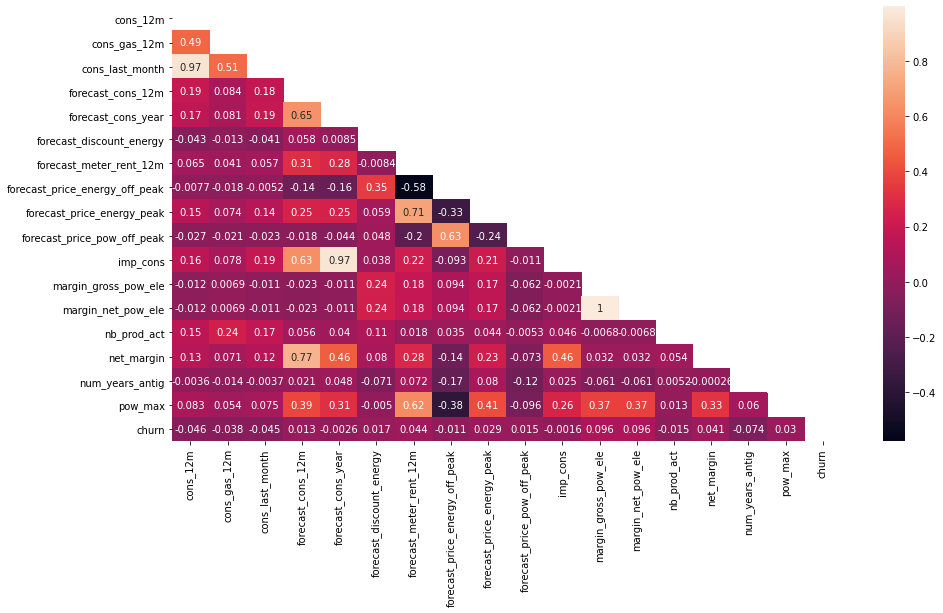

In [4]:
# Visulaizing the correlation between columns in client_data
corr=client_data.corr()
plt.figure(figsize=(15,8))
mask=np.triu(np.ones_like(corr,dtype='bool'))
sns.heatmap(corr,mask=mask,annot=True)

# Feature Engineering
__________________________________
1. Creating Features
2. Creating Dummies for catagorical columns
3. Scalling 
4. Removing Outliers

### 1. Creating Features

In [5]:
#the difference between off-peak prices in December and January the preceding year
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
# Merging the diff dataframe with client_data
data=client_data.merge(diff,on='id')
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,-0.006192,0.162916


In [7]:
#converting the date columns to DateTime
data['date_activ']=pd.to_datetime(data['date_activ'])
data['date_end']=pd.to_datetime(data['date_end'])
data['date_modif_prod']=pd.to_datetime(data['date_modif_prod'])
data['date_renewal']=pd.to_datetime(data['date_renewal'])


In [8]:
#Creating a Tenure column that will represent the difference between date_end and date_activ
data['tenure']=(data['date_end']-data['date_activ'])
data['tenure']=round(data['tenure']/ np.timedelta64(1,'Y'))
data.tenure

0        3.0
1        7.0
2        6.0
3        6.0
4        6.0
        ... 
14601    4.0
14602    4.0
14603    4.0
14604    4.0
14605    7.0
Name: tenure, Length: 14606, dtype: float64

<AxesSubplot:>

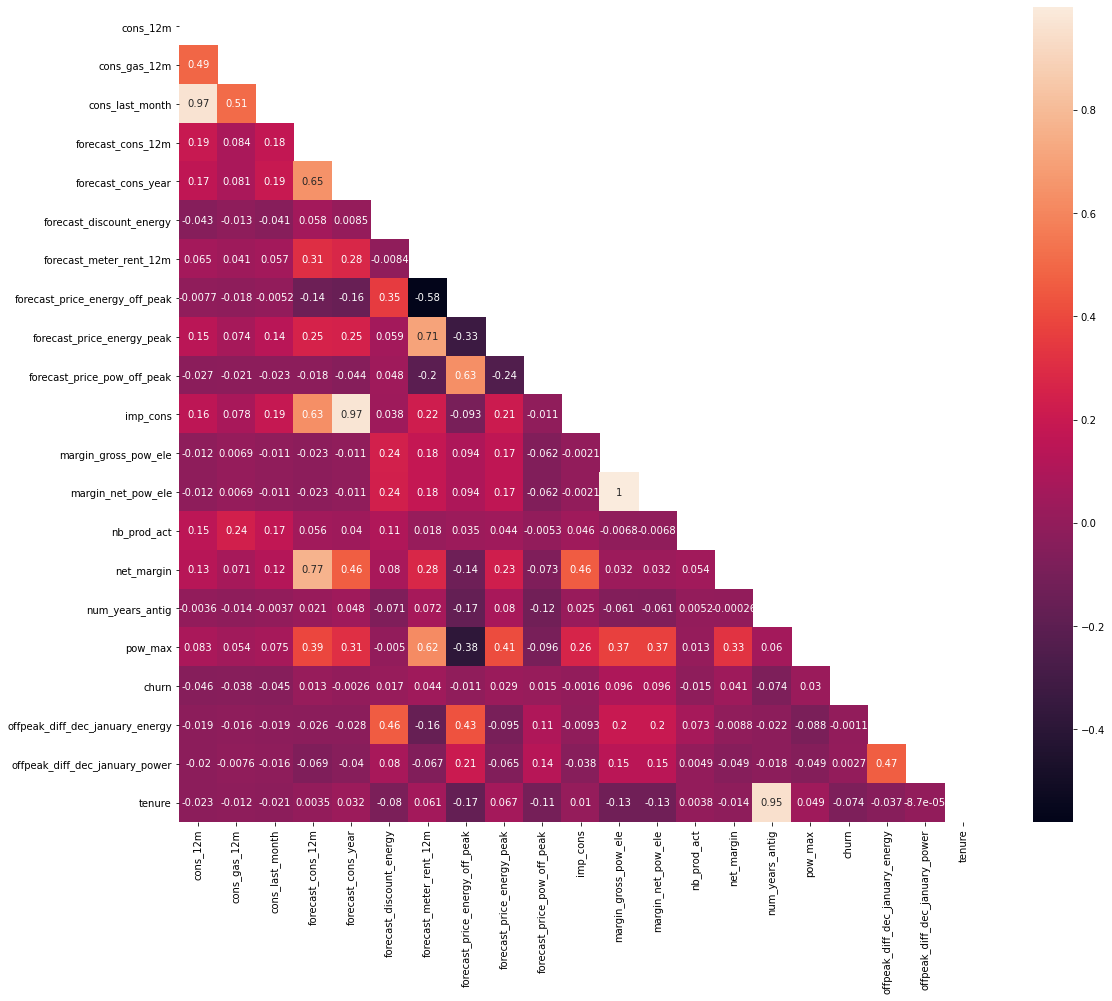

In [9]:
# Visulaizing the correlation between columns in data
corr=data.corr()
plt.figure(figsize=(18,15))
mask=np.triu(np.ones_like(corr,dtype='bool'))
sns.heatmap(corr,mask=mask,annot=True)

In [10]:
# Creating average year price and last 6 months
var_year=price_df.groupby(by=['id','price_date']).mean().groupby(by='id').var().reset_index()
var_6m=price_df[price_df['price_date']>'2015-06-01'].groupby(by=['id','price_date']).mean().groupby(by='id').var().reset_index()

In [11]:
var_year.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.000016,0.000004,1.871602e-06,4.021438e-03,0.001448,0.000643
1,0004351ebdd665e6ee664792efc4fd13,0.000005,0.000000,0.000000e+00,7.661891e-03,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000676,0.000000,0.000000e+00,5.965909e-01,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.000025,0.000007,1.627620e-07,7.238536e-03,0.002606,0.001158
4,00114d74e963e47177db89bc70108537,0.000005,0.000000,0.000000e+00,3.490909e-13,0.000000,0.000000


In [12]:
#Adding the peak_var columns to peak_fix columns
var_year['var_year_price_p1']=var_year['price_off_peak_var']+var_year['price_off_peak_fix']
var_year['var_year_price_p2']=var_year['price_peak_var']+var_year['price_peak_fix']
var_year['var_year_price_p3']=var_year['price_mid_peak_var']+var_year['price_mid_peak_fix']

In [13]:
var_6m.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.000011,0.000003,4.860000e-10,0.0,0.0,0.0
1,0004351ebdd665e6ee664792efc4fd13,0.000003,0.000000,0.000000e+00,0.0,0.0,0.0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000003,0.000000,0.000000e+00,0.0,0.0,0.0
3,0010ee3855fdea87602a5b7aba8e42de,0.000011,0.000003,4.860000e-10,0.0,0.0,0.0
4,00114d74e963e47177db89bc70108537,0.000003,0.000000,0.000000e+00,0.0,0.0,0.0


In [14]:
#Adding the peak_var columns to peak_fix columns
var_6m['var_year_price_p1']=var_6m['price_off_peak_var']+var_6m['price_off_peak_fix']
var_6m['var_year_price_p2']=var_6m['price_peak_var']+var_6m['price_peak_fix']
var_6m['var_year_price_p3']=var_6m['price_mid_peak_var']+var_6m['price_mid_peak_fix']

In [15]:
# combining on one dataframe
var_year = var_year.rename(
    index=str, 
    columns={
        "price_p1_var": "var_year_price_p1_var",
        "price_p2_var": "var_year_price_p2_var",
        "price_p3_var": "var_year_price_p3_var",
        "price_p1_fix": "var_year_price_p1_fix",
        "price_p2_fix": "var_year_price_p2_fix",
        "price_p3_fix": "var_year_price_p3_fix"
    }
)

In [16]:
var_6m = var_6m.rename(
    index=str, 
    columns={
        "price_p1_var": "var_year_6m_p1_var",
        "price_p2_var": "var_year_6m_p2_var",
        "price_p3_var": "var_year_6m_p3_var",
        "price_p1_fix": "var_year_6m_p1_fix",
        "price_p2_fix": "var_year_6m_p2_fix",
        "price_p3_fix": "var_year_6m_p3_fix"
    }
)

In [17]:
#merging to the main data
data=data.merge(var_year,on='id')
data=data.merge(var_6m,on='id')

In [18]:
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_year_price_p3_x,price_off_peak_var_y,price_peak_var_y,price_mid_peak_var_y,price_off_peak_fix_y,price_peak_fix_y,price_mid_peak_fix_y,var_year_price_p1_y,var_year_price_p2_y,var_year_price_p3_y
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10


### 2. Creating Dummies

In [19]:
#value counts for channel_sales
counts=data['channel_sales'].value_counts()
#set all the channel_sales the=at are less than 100 to 'other'
mask=data['channel_sales'].isin(counts[counts<100].index)
data['channel_sales'][mask]='other'
data['channel_sales'].value_counts()

<ipython-input-19-1a1b004197a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['channel_sales'][mask]='other'


foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
other                                 16
Name: channel_sales, dtype: int64

In [20]:
#create dummies for channel_sales column
channel_sales=pd.get_dummies(data['channel_sales'],prefix='channel',drop_first=True)
#Renaming the column
channel_sales.columns=[col_name[:10] for col_name in channel_sales.columns ]
channel_sales.head()

,channel_ew,channel_fo,channel_lm,channel_ot,channel_us
0,0,1,0,0,0
1,0,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0


In [21]:
#value counts for origin_up
counts=data['origin_up'].value_counts()
#set all the origin_up that are less than 100 to 'other'
mask=data['origin_up'].isin(counts[counts<100].index)
data['origin_up'][mask]='other'
data['origin_up'].value_counts()

<ipython-input-21-2113f5aa8ff1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['origin_up'][mask]='other'


lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
other                                 67
Name: origin_up, dtype: int64

In [22]:
#create dummies for origin_up  column
origin_up=pd.get_dummies(data['origin_up'],prefix='origin',drop_first=True)
#Renaming the column
origin_up.columns=[col_name[:10] for col_name in origin_up.columns ]
origin_up.head()

,origin_ldk,origin_lxi,origin_oth
0,0,1,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [23]:
# Merging the dummies dataframe to our dataset
data=data.merge(channel_sales,left_index=True,right_index=True)
data=data.merge(origin_up,left_index=True,right_index=True)
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_year_price_p2_y,var_year_price_p3_y,channel_ew,channel_fo,channel_lm,channel_ot,channel_us,origin_ldk,origin_lxi,origin_oth
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.953056e+01,4.423670e+01,0,1,0,0,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,1.217891e-03,0.000000e+00,0,0,0,0,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,9.450150e-08,0.000000e+00,0,1,0,0,0,0,0,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000e+00,0,0,1,0,0,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,2.896760e-06,4.860000e-10,0,0,0,0,0,0,0,0


In [24]:
#droping the unimportant columns
data=data.drop(['channel_sales','origin_up','date_activ','id','date_activ','date_end','date_modif_prod','date_renewal'],axis=1)


In [25]:
#coverting the has_gas column's value to 1 and 0 inseatd of 't' and 'f'
data['has_gas']=data['has_gas'].replace({'t':1,'f':0})

In [26]:
#checking the types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14606 entries, 0 to 14605
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cons_12m                         14606 non-null  int64  
 1   cons_gas_12m                     14606 non-null  int64  
 2   cons_last_month                  14606 non-null  int64  
 3   forecast_cons_12m                14606 non-null  float64
 4   forecast_cons_year               14606 non-null  int64  
 5   forecast_discount_energy         14606 non-null  float64
 6   forecast_meter_rent_12m          14606 non-null  float64
 7   forecast_price_energy_off_peak   14606 non-null  float64
 8   forecast_price_energy_peak       14606 non-null  float64
 9   forecast_price_pow_off_peak      14606 non-null  float64
 10  has_gas                          14606 non-null  int64  
 11  imp_cons                         14606 non-null  float64
 12  margin_gross_pow_e

### 3. Scaling

from our EDA visualization we knew that most of continues columns are highly skewed to the right so we will use the log scaller to scale them.

##### Checking for some particular columns

In [27]:
#understaning forecast_discount_energy column
data['forecast_discount_energy'].describe()

count    14606.000000
mean         0.966726
std          5.108289
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: forecast_discount_energy, dtype: float64

C:\Users\H\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='forecast_discount_energy', ylabel='Density'>

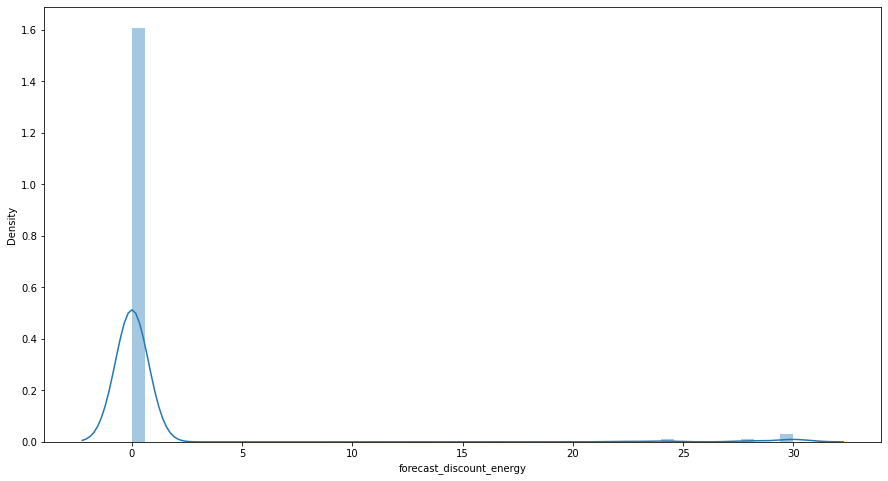

In [28]:
#ploting the distribution of the column
plt.figure(figsize=(15,8))
sns.distplot(data['forecast_discount_energy'])

> almost 90% of the entries are zero

Let's check if there is trend with churn column

In [29]:
#checking the correlation between it and churn
forecast_discount_energy=data[data['forecast_discount_energy']>0]
forecast_discount_energy[['forecast_discount_energy','churn']]

,forecast_discount_energy,churn
31,30.0,0
57,24.0,0
88,28.0,0
106,30.0,0
129,30.0,0
...,...,...
14483,28.0,1
14526,30.0,0
14531,23.0,0
14533,24.0,0


In [30]:
data['churn'].value_counts()

0    13187
1     1419
Name: churn, dtype: int64

In [31]:
#droping forecast_discount_energy column
data=data.drop(['forecast_discount_energy'],axis=1)

In [32]:
#understaning forecast_price_energy_peak column
data.forecast_price_energy_peak.describe()

count    14606.000000
mean         0.050491
std          0.049037
min          0.000000
25%          0.000000
50%          0.084138
75%          0.098837
max          0.195975
Name: forecast_price_energy_peak, dtype: float64

C:\Users\H\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='forecast_price_energy_peak', ylabel='Density'>

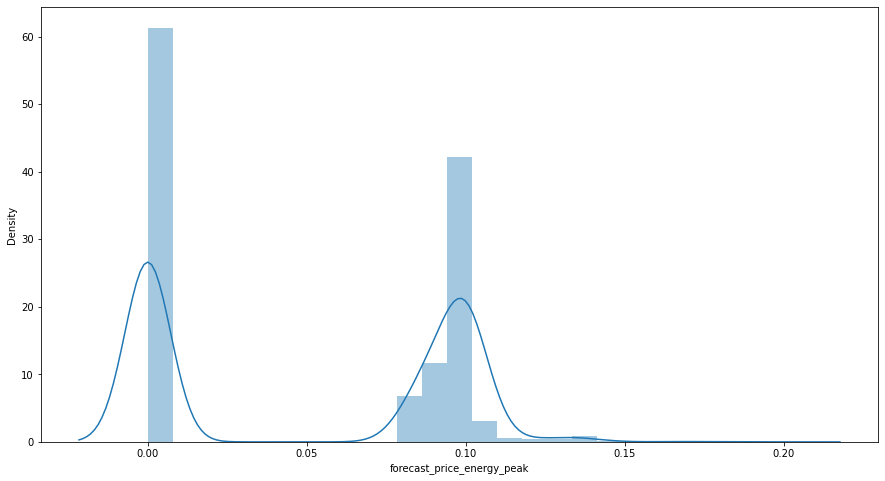

In [33]:
plt.figure(figsize=(15,8))
sns.distplot(data.forecast_price_energy_peak)

In [34]:
#checking the numbur of zero value in forecast_price_energy_peak coulmn
zero=data['forecast_price_energy_peak'][data['forecast_price_energy_peak']==0].count()
print('Zero entites in forecast_price_energy_peak columns id {}'.format(zero))
print('Nanzero entites in forecast_price_energy_peak columns id {}'.format(data['forecast_price_energy_peak'].count()-zero))


Zero entites in forecast_price_energy_peak columns id 7021
Nanzero entites in forecast_price_energy_peak columns id 7585


In [35]:
# scaling 
from sklearn.preprocessing import PowerTransformer
pow_trans = PowerTransformer()
scale=data.drop(['channel_ew','channel_fo','channel_lm','channel_ot','channel_us','origin_ldk','origin_lxi','origin_oth','tenure',
          'num_years_antig','has_gas','churn'],axis=1).columns
data[scale]=pow_trans.fit_transform(data[scale])

In [36]:
data['churn']

0        1
1        0
2        0
3        0
4        0
        ..
14601    0
14602    1
14603    1
14604    0
14605    0
Name: churn, Length: 14606, dtype: int64

C:\Users\H\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cons_12m', ylabel='Density'>

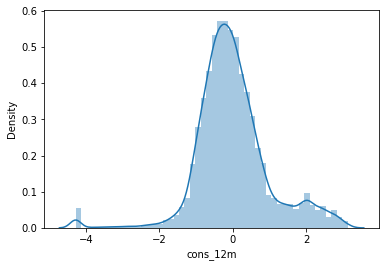

In [37]:
sns.distplot(data['cons_12m'])

# 4. Removing the outliers

In [38]:
data['cons_12m'].count()

14606

In [39]:
data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,var_year_price_p2_y,var_year_price_p3_y,channel_ew,channel_fo,channel_lm,channel_ot,channel_us,origin_ldk,origin_lxi,origin_oth
0,-4.280929,2.160341,-1.251502,-2.612719,-1.116591,-1.695059,-0.927814,0.972152,-0.755337,1,...,6.714365,6.576838,0,1,0,0,0,0,1,0
1,-0.646618,-0.466538,-1.251502,-1.191201,-1.116591,-0.591072,0.336334,-1.030113,0.265474,0,...,-0.104369,-0.202029,0,0,0,0,0,0,0,0
2,-1.644613,-0.466538,-1.251502,-1.766172,-1.116591,0.038246,1.161217,0.766739,0.265474,0,...,-0.211999,-0.202029,0,1,0,0,0,0,0,0
3,-1.154945,-0.466538,-1.251502,-1.070040,-1.116591,-0.457136,0.376493,-1.030113,0.265474,0,...,-0.212008,-0.202029,0,0,1,0,0,0,0,0
4,-0.671315,-0.466538,0.199090,-0.710098,0.552272,1.123683,-0.830708,1.009628,-0.755337,0,...,-0.211749,-0.202029,0,0,0,0,0,0,0,0


In [40]:
#Removing outliers

for i in scale:
    std=data[i].std()
    mean=data[i].mean()
    cut_off=3*std
    lower,upper=mean-cut_off,mean+cut_off
    data=data[(data[i]<upper) & (data[i]> lower)]

In [41]:
data['cons_12m'].count()

9564

# Modeling

In [42]:
#spliting the data to X and y
X=data.drop('churn',axis=1)
y=data['churn']

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#spliting the data to training and testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1111)

In [44]:
X_test.shape

(1913, 46)

In [45]:
rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [46]:
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

1.0
0.9236800836382645


In [47]:
# creating a function to evaluate the model
def evaluation(model,y_pred):
    train_score=model.score(X_train,y_train)
    test_score=model.score(X_test,y_test)
    print('the training score is {}'.format(round(train_score,2)))
    print('the test score is {}'.format(round(test_score,2)))
    print('_________________________________')
    from sklearn.metrics import confusion_matrix,recall_score,precision_score,accuracy_score
    print('The confusion matrix is')
    print(confusion_matrix(y_test,y_pred))
    print('_________________________________')
    recall=recall_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    accuracy=accuracy_score(y_test,y_pred)
    print('recall score is {}'.format(round(recall,2)))
    print('precision score is {}'.format(round(precision,2)))
    print('Accuracy score is {}'.format(round(accuracy,2)))

In [48]:
y_test.value_counts()

0    1757
1     156
Name: churn, dtype: int64

In [49]:
evaluation(rf,y_pred)

the training score is 1.0
the test score is 0.92
_________________________________
The confusion matrix is
[[1755    2]
 [ 144   12]]
_________________________________
recall score is 0.08
precision score is 0.86
Accuracy score is 0.92


<ul>
    <li>so out of 1757 of the negative values, the model predected 1755 right which is very great</li>
    <li> but out of 156 of the posivtive values the model predected 12 right which is very poor performance</li>
</ul>
so know we will try some techniques to get a better result

# Oversampling

In [50]:
from imblearn.over_sampling import SMOTE
oversampling=SMOTE()
X,y=oversampling.fit_resample(X,y)
y.value_counts()

0    8690
1    8690
Name: churn, dtype: int64

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

1.0
0.9548331415420023


In [53]:
y_test.value_counts()

0    1748
1    1728
Name: churn, dtype: int64

In [52]:
evaluation(rf,y_pred)

the training score is 1.0
the test score is 0.95
_________________________________
The confusion matrix is
[[1723   25]
 [ 132 1596]]
_________________________________
recall score is 0.92
precision score is 0.98
Accuracy score is 0.95


<ul>
    <li>so out of 1748 of the negative values, the model predected 1723 right which is still very great</li>
    <li> but out of 1728 of the posivtive values the model predected 1596 right which is awesome</li>
</ul>
so know we will Tune our model to get the best result as we can

# Tunning

In [54]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3,scoring='recall' ,verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='recall', verbose=2)

In [55]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [56]:
rf_random.best_score_

0.9199936734562492

In [57]:
model_random=rf_random.best_estimator_
y_pred=model_random.predict(X_test)
evaluation(model_random,y_pred)

the training score is 1.0
the test score is 0.96
_________________________________
The confusion matrix is
[[1729   19]
 [ 104 1624]]
_________________________________
recall score is 0.94
precision score is 0.99
Accuracy score is 0.96


In [58]:
cv_result_df=pd.DataFrame(rf_random.cv_results_)
cv_result_df.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,13.167264,0.090021,0.746203,0.019563,400,5,1,sqrt,30,True,"{'n_estimators': 400, 'min_samples_split': 5, ...",0.898320,0.921155,0.903879,0.907785,0.009723,22
1,50.310577,0.577572,2.523315,0.072866,2000,5,1,sqrt,10,True,"{'n_estimators': 2000, 'min_samples_split': 5,...",0.846618,0.855235,0.851293,0.851049,0.003522,93
2,43.677405,0.272100,1.487967,0.019660,1200,5,2,sqrt,10,False,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.852219,0.861267,0.852586,0.855357,0.004181,90
3,94.511992,2.039816,4.211830,0.224841,2000,2,4,auto,30,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.889703,0.914692,0.894828,0.899741,0.010777,51
4,40.223621,0.405882,2.315161,0.416811,1600,2,4,sqrt,10,True,"{'n_estimators': 1600, 'min_samples_split': 2,...",0.832831,0.846618,0.841810,0.840420,0.005714,98
5,36.978285,0.409742,1.491189,0.100759,800,5,4,sqrt,30,False,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.890564,0.913830,0.893103,0.899166,0.010421,59
6,48.637636,0.592583,1.828771,0.016741,1000,5,2,sqrt,100,False,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.902628,0.922878,0.905172,0.910226,0.009006,20
7,29.496258,0.565070,1.089976,0.029896,600,5,1,sqrt,60,False,"{'n_estimators': 600, 'min_samples_split': 5, ...",0.910814,0.924601,0.907328,0.914248,0.007458,10
8,49.583988,1.171266,1.846472,0.026996,1000,2,1,auto,50,False,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.913399,0.929341,0.916810,0.919850,0.006854,2
9,63.854028,0.648524,2.267733,0.071713,1800,5,4,auto,10,False,"{'n_estimators': 1800, 'min_samples_split': 5,...",0.844894,0.852650,0.851724,0.849756,0.003458,95


<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

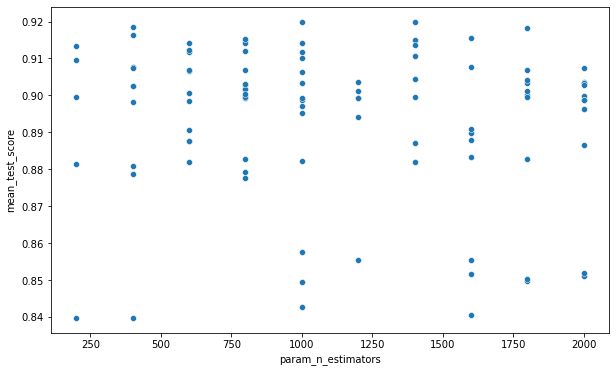

In [59]:
# analyzing the result
# visualize n_estimators and the recall score
plt.figure(figsize=(10,6))
sns.scatterplot(data=cv_result_df,x='param_n_estimators',y='mean_test_score')

The figure shows that n_estimators that have the best recall score is between 400 and 1000

<AxesSubplot:xlabel='param_min_samples_split', ylabel='mean_test_score'>

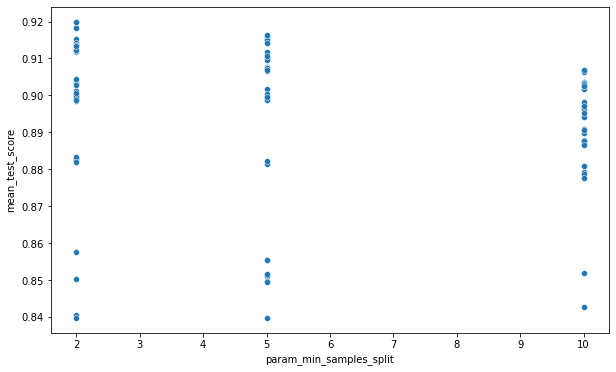

In [60]:
# visualize min_samples_split and the recall score
plt.figure(figsize=(10,6))
sns.scatterplot(data=cv_result_df,x='param_min_samples_split',y='mean_test_score')

The best number for min_samples_split is 2 (the defult)

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

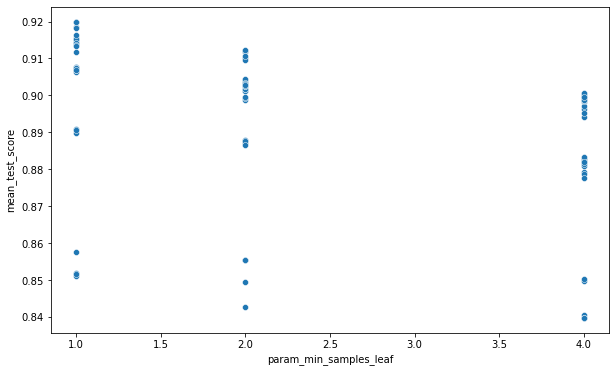

In [61]:
# visualize min_samples_leaf and the recall score
plt.figure(figsize=(10,6))
sns.scatterplot(data=cv_result_df,x='param_min_samples_leaf',y='mean_test_score')

The best number of min_samples_leaf is 1

<AxesSubplot:xlabel='param_max_features', ylabel='mean_test_score'>

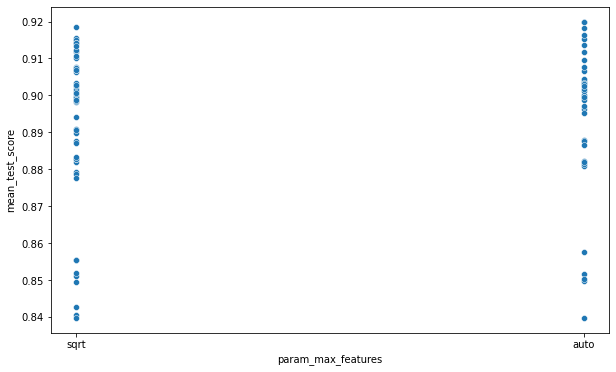

In [62]:
# visualize max_features and the recall score
plt.figure(figsize=(10,6))
sns.scatterplot(data=cv_result_df,x='param_max_features',y='mean_test_score')

It's hard to detect which one of the param_max_features is the best

<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_score'>

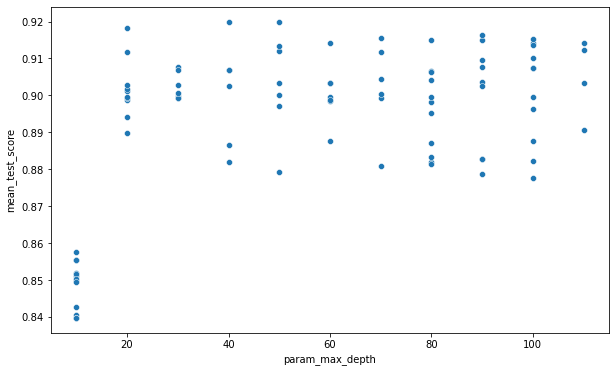

In [63]:
# visualize max_depth and the recall score
plt.figure(figsize=(10,6))
sns.scatterplot(data=cv_result_df,x='param_max_depth',y='mean_test_score')

best numbers for max_depth is [40,50]

<AxesSubplot:xlabel='param_bootstrap', ylabel='mean_test_score'>

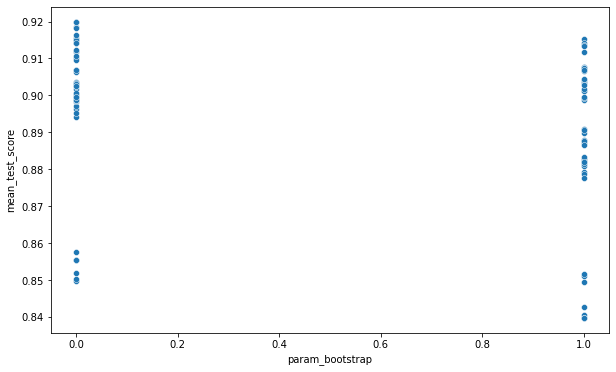

In [64]:
# visualize bootstrap and the recall score
plt.figure(figsize=(10,6))
sns.scatterplot(data=cv_result_df,x='param_bootstrap',y='mean_test_score')

we will work with false 

In [65]:
from sklearn.model_selection import GridSearchCV
params={'n_estimators':[400,500,1000],'max_depth':[40,50],'max_features':['auto','sqrt']}
rf=RandomForestClassifier(bootstrap=False,min_samples_leaf=1,min_samples_split=2)
grid=GridSearchCV(rf,params,cv=3,n_jobs=-1,scoring='recall',refit=True)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(bootstrap=False), n_jobs=-1,
             param_grid={'max_depth': [40, 50],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [400, 500, 1000]},
             scoring='recall')

In [66]:
grid.best_params_

{'max_depth': 40, 'max_features': 'auto', 'n_estimators': 500}

In [67]:
y_test.value_counts()

0    1748
1    1728
Name: churn, dtype: int64

In [69]:
model_grid=grid.best_estimator_
y_pred=model_grid.predict(X_test)
evaluation(model_grid,y_pred)

the training score is 1.0
the test score is 0.96
_________________________________
The confusion matrix is
[[1728   20]
 [ 106 1622]]
_________________________________
recall score is 0.94
precision score is 0.99
Accuracy score is 0.96


In [71]:
feature_importance=pd.DataFrame({'feature':X_train.columns,'importance':model_grid.feature_importances_}).sort_values(
    by='importance',ascending=False).reset_index()
feature_importance.head()

,index,feature,importance
0,26,var_year_price_p1_x,0.077464
1,23,price_off_peak_fix_x,0.069142
2,18,offpeak_diff_dec_january_power,0.065732
3,11,margin_gross_pow_ele,0.051073
4,12,margin_net_pow_ele,0.048724


<AxesSubplot:xlabel='importance', ylabel='feature'>

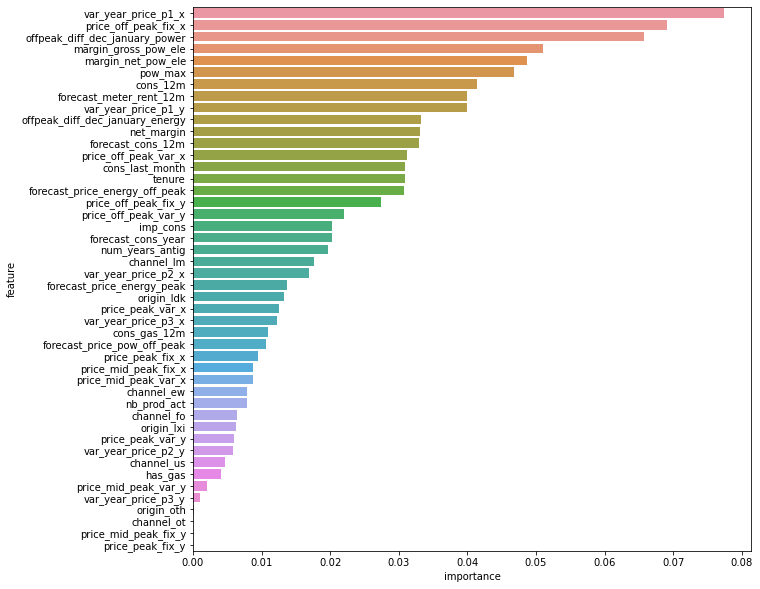

In [72]:
plt.figure(figsize=(10,10))
sns.barplot(data=feature_importance,x='importance',y='feature')